# Shipment Delay Prediction 

In [9]:
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns  # Add this import for Seaborn
import xgboost as xgb
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, roc_curve

# Specify the path to the zip file
zip_file_path = 'Delayed Shipments.zip'

# Open the zip file
with zipfile.ZipFile(zip_file_path, 'r') as z:
    # List all the files in the zip archive
    print("Files in the zip archive:", z.namelist())
    
    # Load the training CSV file into a pandas DataFrame
    with z.open('Is_delayed_prediction_Train_3_Avatar_2_Version_1_05_09_2019.csv') as train_file:
        train_df = pd.read_csv(train_file)
        
    # Load the testing CSV file into a pandas DataFrame
    with z.open('Is_delayed_prediction_Test_3_Avatar_2_Version_1_05_09_2019.csv') as test_file:
        test_df = pd.read_csv(test_file)

# Display the first few rows of the train and test data
print("\nTraining Data (first 5 rows):")
print(train_df.head())

print("\nTesting Data (first 5 rows):")
print(test_df.head())

Files in the zip archive: ['Is_delayed_prediction_Test_3_Avatar_2_Version_1_05_09_2019.csv', 'Is_delayed_prediction_Train_3_Avatar_2_Version_1_05_09_2019.csv']

Training Data (first 5 rows):
   is_delayed  actual_TAT  SLA  is_sunday_in_between  holiday_in_between  \
0           0           1    1                     1                   0   
1           0           0    1                     1                   0   
2           0           1    1                     1                   1   
3           0           2    4                     1                   1   
4           0           1    1                     0                   0   

   pickup_lat  pickup_lon  drop_lat  drop_lon    distance  ...  \
0     28.5800     77.3300   28.6625   77.4378   13.959545  ...   
1     19.2565     72.8733   19.1309   72.8526   14.134243  ...   
2     29.7732     77.1966   28.2636   77.3990  169.009509  ...   
3     29.7732     77.1966   26.4498   74.6412  446.478107  ...   
4     26.6970     83.1

In [10]:
# Exploratory Data Analysis (EDA)

Number of duplicate rows in the dataset: 220

Numerical Features: Index(['is_delayed', 'actual_TAT', 'SLA', 'is_sunday_in_between',
       'holiday_in_between', 'pickup_lat', 'pickup_lon', 'drop_lat',
       'drop_lon', 'distance',
       ...
       'pickup_time_14', 'pickup_time_15', 'pickup_time_16', 'pickup_time_17',
       'pickup_time_18', 'pickup_time_19', 'pickup_time_20', 'pickup_time_21',
       'pickup_time_22', 'pickup_time_23'],
      dtype='object', length=200)
Categorical Features: Index([], dtype='object')


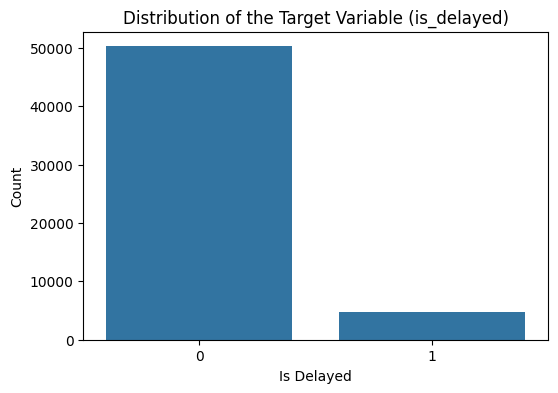

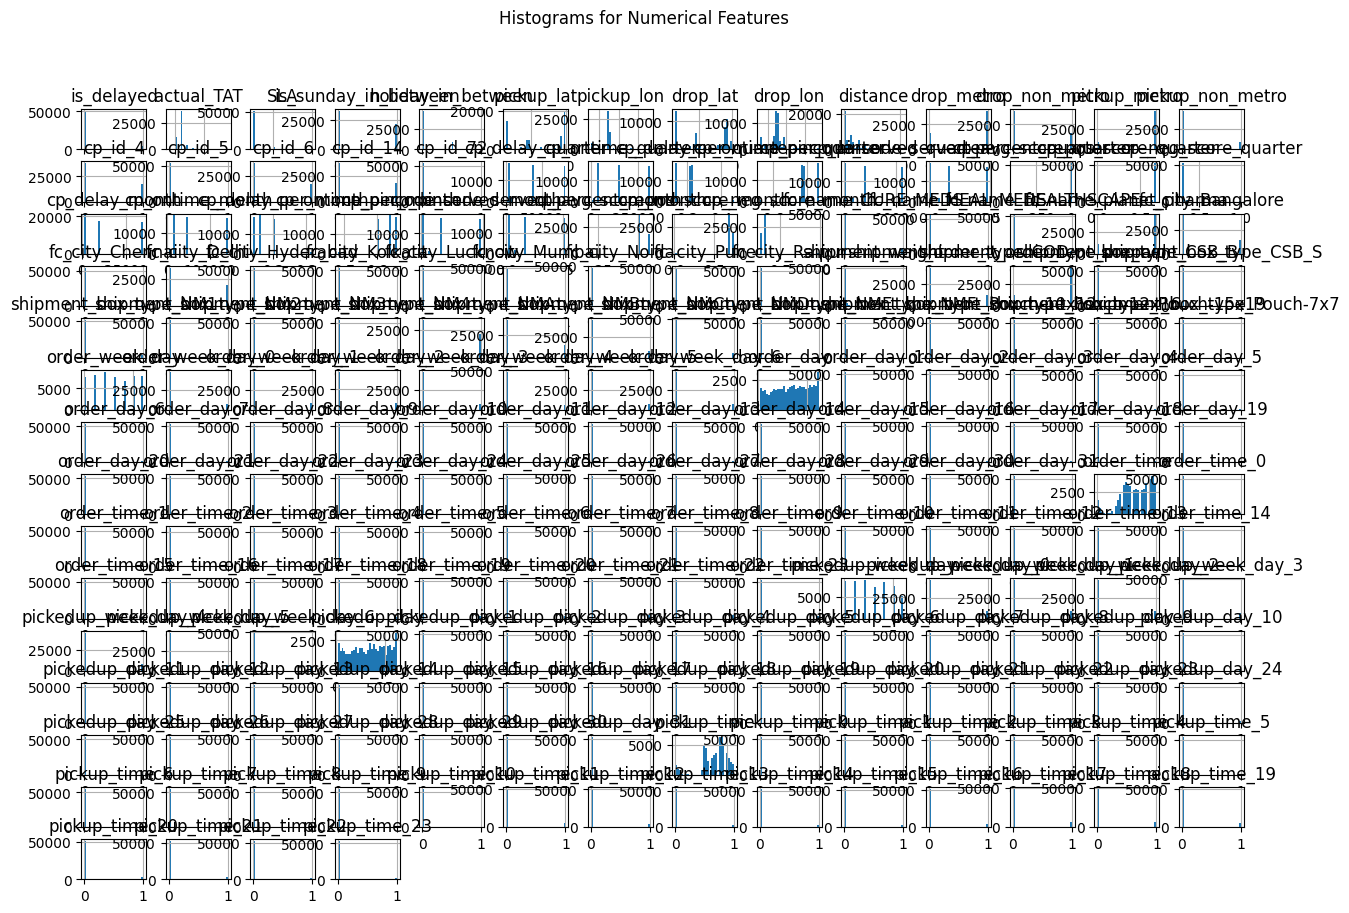

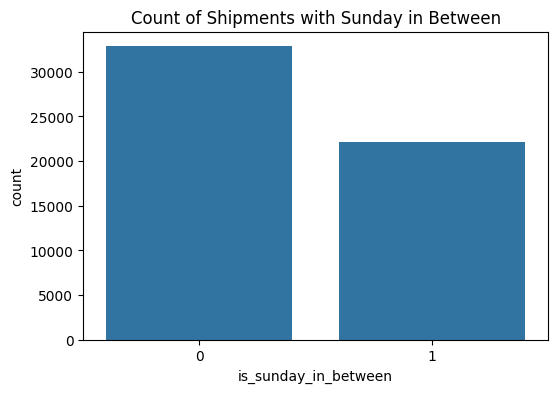

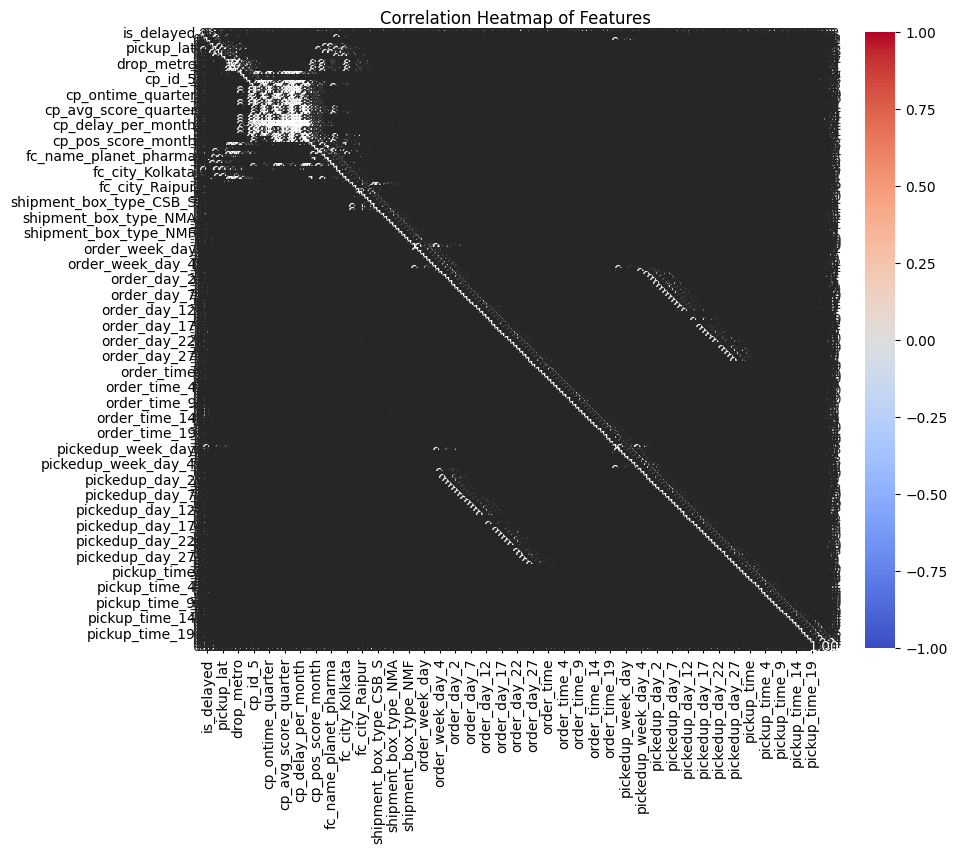

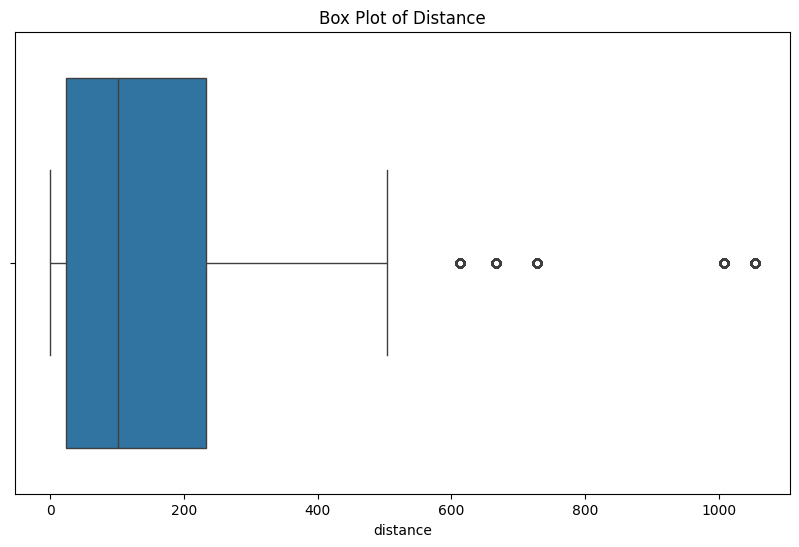

In [11]:
# 1. Check for duplicates
duplicates = train_df.duplicated().sum()
print(f"Number of duplicate rows in the dataset: {duplicates}")

# 2. Identify numerical and categorical features
numerical_features = train_df.select_dtypes(include=['float64', 'int64']).columns
categorical_features = train_df.select_dtypes(include=['object']).columns
print(f"\nNumerical Features: {numerical_features}")
print(f"Categorical Features: {categorical_features}")

# 3. Examine the distribution of the target variable 'is_delayed'
plt.figure(figsize=(6, 4))
sns.countplot(x='is_delayed', data=train_df)
plt.title('Distribution of the Target Variable (is_delayed)')
plt.xlabel('Is Delayed')
plt.ylabel('Count')
plt.show()

# 4. Histograms for numerical features
train_df[numerical_features].hist(bins=30, figsize=(15, 10))
plt.suptitle('Histograms for Numerical Features')
plt.show()

# 5. Bar plot for categorical features
plt.figure(figsize=(6, 4))
sns.countplot(x='is_sunday_in_between', data=train_df)
plt.title('Count of Shipments with Sunday in Between')
plt.show()

# 6. Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(train_df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap of Features')
plt.show()

# 7. Box plots for detecting outliers in 'distance', 'SLA', and 'actual_TAT'
plt.figure(figsize=(10, 6))
sns.boxplot(x='distance', data=train_df)
plt.title('Box Plot of Distance')
plt.show()


In [12]:
# Feature Engineering

In [13]:
# 1. Remove duplicate rows
train_df = train_df.drop_duplicates()
print(f"Number of rows after removing duplicates: {train_df.shape[0]}")

# 2. Calculate distance between pickup and drop-off using Haversine Formula (if not already calculated)
def haversine(lat1, lon1, lat2, lon2):
    # Convert degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    # Radius of Earth in kilometers (6371)
    km = 6371 * c
    return km

# Apply the haversine formula to calculate distance (if it's not already computed)
if 'distance' not in train_df.columns:
    train_df['calculated_distance'] = haversine(train_df['pickup_lat'], train_df['pickup_lon'],
                                                train_df['drop_lat'], train_df['drop_lon'])
    print("Calculated distance between pickup and drop-off points.")
else:
    print("Distance column already present, skipping calculation.")

# 3. Geographical Zones (Urban/Non-Urban based on latitude and longitude)
# You can categorize the regions based on metropolitan areas or create zones
# Here's an example based on a simple latitude threshold for demonstration

def categorize_zone(lat):
    if lat > 25:  # Arbitrary threshold, customize based on region or external data
        return 'Urban'
    else:
        return 'Rural'

train_df['pickup_zone'] = train_df['pickup_lat'].apply(categorize_zone)
train_df['drop_zone'] = train_df['drop_lat'].apply(categorize_zone)

# 4. Encoding Categorical Variables (if any)
# Since there are no categorical features, we don't need to do one-hot encoding.
# But, if there are zones, you can one-hot encode them like this:

train_df = pd.get_dummies(train_df, columns=['pickup_zone', 'drop_zone'], drop_first=True)

# 5. Check the updated DataFrame
print("\nUpdated Training Data (first 5 rows):")
print(train_df.head())

Number of rows after removing duplicates: 54757
Distance column already present, skipping calculation.

Updated Training Data (first 5 rows):
   is_delayed  actual_TAT  SLA  is_sunday_in_between  holiday_in_between  \
0           0           1    1                     1                   0   
1           0           0    1                     1                   0   
2           0           1    1                     1                   1   
3           0           2    4                     1                   1   
4           0           1    1                     0                   0   

   pickup_lat  pickup_lon  drop_lat  drop_lon    distance  ...  \
0     28.5800     77.3300   28.6625   77.4378   13.959545  ...   
1     19.2565     72.8733   19.1309   72.8526   14.134243  ...   
2     29.7732     77.1966   28.2636   77.3990  169.009509  ...   
3     29.7732     77.1966   26.4498   74.6412  446.478107  ...   
4     26.6970     83.1876   26.6970   83.1876    0.000000  ...   

   p

In [14]:
# Data PreProcessing

In [15]:
# 1. Check for boolean columns and convert them to integers
boolean_cols = train_df.select_dtypes(include=['bool']).columns
train_df[boolean_cols] = train_df[boolean_cols].astype(int)

# 2. Define the columns for numerical and categorical data
numerical_cols = train_df.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_cols = train_df.select_dtypes(include=['object']).columns.tolist()

# Remove the target column 'is_delayed' from numerical features list
numerical_cols.remove('is_delayed')

# 3. Imputer for numerical data (mean imputation) and categorical data (mode imputation)
num_imputer = SimpleImputer(strategy='mean')
cat_imputer = SimpleImputer(strategy='most_frequent')

# 4. Scaling for numerical data and encoding for categorical data
scaler = StandardScaler()
encoder = OneHotEncoder(handle_unknown='ignore')

# 5. Create a column transformer for both numerical and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[('imputer', num_imputer), ('scaler', scaler)]), numerical_cols),
        ('cat', Pipeline(steps=[('imputer', cat_imputer), ('encoder', encoder)]), categorical_cols)
    ])

# 6. Split data into features (X) and target variable (y)
X = train_df.drop('is_delayed', axis=1)  # Features
y = train_df['is_delayed']  # Target variable

# 7. Apply the preprocessor pipeline
X_preprocessed = preprocessor.fit_transform(X)

# 8. Check the resulting preprocessed data
print(f"\nShape of preprocessed data: {X_preprocessed.shape}")
print("First 5 rows of preprocessed data:")
print(X_preprocessed[:5])


Shape of preprocessed data: (54757, 199)
First 5 rows of preprocessed data:
[[ 6.14439714e-02 -2.40861682e-01  1.21967113e+00 -4.28152372e-01
   8.36214638e-01  2.08191478e-02  9.36473597e-01  6.66034316e-02
  -7.25111296e-01 -1.51271733e+00  1.51271733e+00 -2.25255140e+00
   2.25255140e+00  1.49023842e+00 -1.69314813e-01 -6.80868693e-01
  -7.02598249e-01 -1.20912260e-01  1.36257370e+00  1.34145516e+00
   3.93879499e-01 -3.93879499e-01  1.40721045e+00  1.40313726e+00
   2.34093472e-02  1.37004338e-02 -1.37004338e-02  1.45086269e+00
   1.43272479e+00  1.04444018e+00 -1.04444018e+00  1.42516851e+00
   1.42375316e+00 -4.16901686e-01 -4.51816502e-03  4.51816502e-03
   2.69864978e+00 -9.46311728e-02 -2.75236075e-01 -1.99981739e+00
  -5.90559923e-01 -9.46311728e-02 -7.45264945e-01 -1.65043846e-01
  -1.44239319e-01 -1.27284994e-01 -3.17626555e-01  2.69864978e+00
  -3.19573917e-01 -8.73888933e-02 -2.33773771e-01  1.88499815e+00
  -1.88499815e+00 -5.41346834e-02 -1.65533272e-02 -2.74352015e-01

In [23]:
# Train-Test Split    

In [25]:
# Split the preprocessed dataset into training and test sets
# We are assuming 'X_preprocessed' contains the features and 'y' contains the target variable
# Test size of 20% is typical, but you can adjust this as needed
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

# Display the sizes of the resulting datasets
print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")
print(f"Training target size: {y_train.shape}")
print(f"Test target size: {y_test.shape}")

Training set size: (43805, 199)
Test set size: (10952, 199)
Training target size: (43805,)
Test target size: (10952,)


In [27]:
# Model Selection


Model: LogisticRegression
Accuracy: 0.9997
AUC-ROC: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10018
           1       1.00      1.00      1.00       934

    accuracy                           1.00     10952
   macro avg       1.00      1.00      1.00     10952
weighted avg       1.00      1.00      1.00     10952



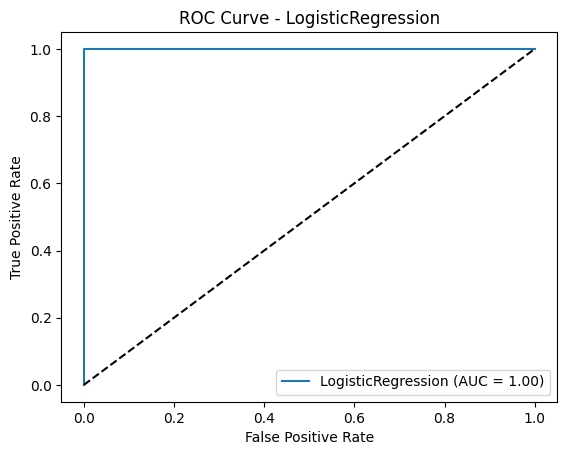


Model: DecisionTreeClassifier
Accuracy: 0.9990
AUC-ROC: 0.9956

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10018
           1       1.00      0.99      0.99       934

    accuracy                           1.00     10952
   macro avg       1.00      1.00      1.00     10952
weighted avg       1.00      1.00      1.00     10952



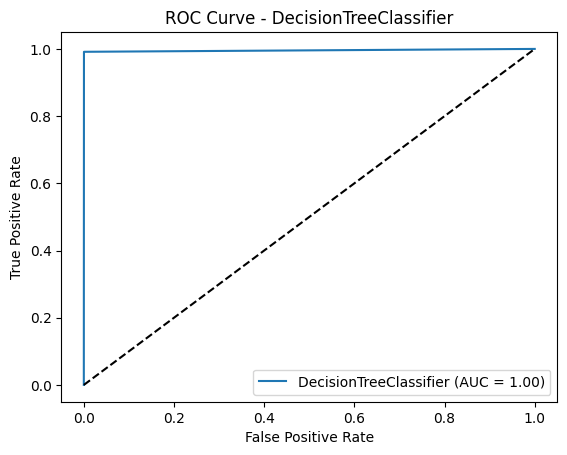


Model: RandomForestClassifier
Accuracy: 0.9980
AUC-ROC: 0.9998

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10018
           1       0.99      0.98      0.99       934

    accuracy                           1.00     10952
   macro avg       1.00      0.99      0.99     10952
weighted avg       1.00      1.00      1.00     10952



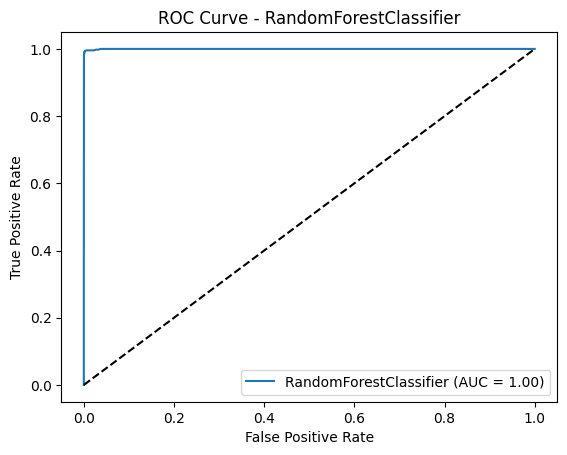

C:\Users\milto\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:36:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Model: XGBClassifier
Accuracy: 0.9995
AUC-ROC: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10018
           1       0.99      1.00      1.00       934

    accuracy                           1.00     10952
   macro avg       1.00      1.00      1.00     10952
weighted avg       1.00      1.00      1.00     10952



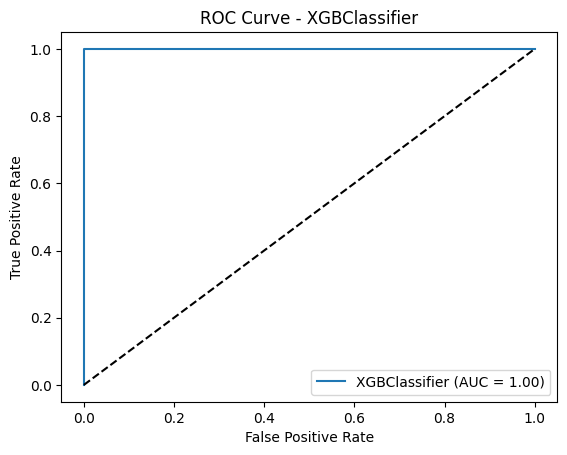

[LightGBM] [Info] Number of positive: 3748, number of negative: 40057
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.687511 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1234
[LightGBM] [Info] Number of data points in the train set: 43805, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.085561 -> initscore=-2.369081
[LightGBM] [Info] Start training from score -2.369081

Model: LGBMClassifier
Accuracy: 0.9996
AUC-ROC: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10018
           1       1.00      1.00      1.00       934

    accuracy                           1.00     10952
   macro avg       1.00      1.00      1.00     10952
weighted avg       1.00      1.00      1.00     10952



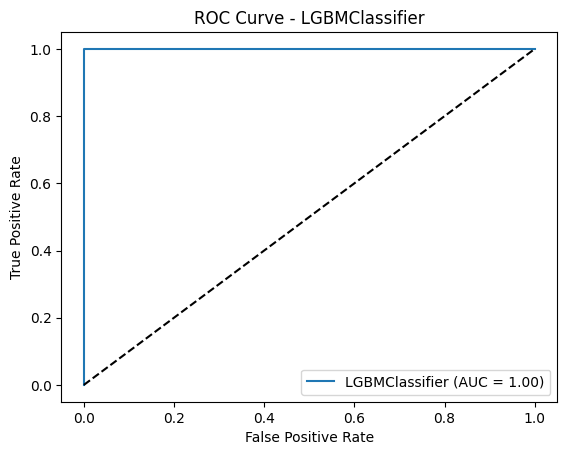


Model: SVC
Accuracy: 0.9968
AUC-ROC: 0.9998

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10018
           1       1.00      0.97      0.98       934

    accuracy                           1.00     10952
   macro avg       1.00      0.98      0.99     10952
weighted avg       1.00      1.00      1.00     10952



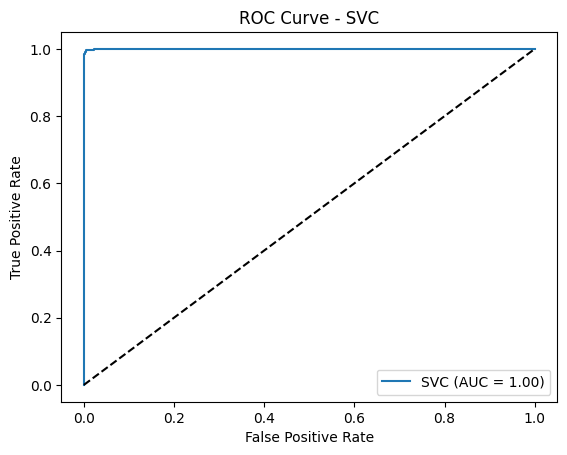

In [29]:
# Function to evaluate models
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else model.decision_function(X_test)
    
    # Evaluate metrics
    accuracy = accuracy_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_pred_proba)
    
    print(f"\nModel: {model.__class__.__name__}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"AUC-ROC: {auc_roc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f'{model.__class__.__name__} (AUC = {auc_roc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model.__class__.__name__}')
    plt.legend()
    plt.show()

# Initialize models
log_reg = LogisticRegression(max_iter=1000, random_state=42)
decision_tree = DecisionTreeClassifier(random_state=42)
random_forest = RandomForestClassifier(random_state=42)
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
lgbm = LGBMClassifier(random_state=42)
svm = SVC(probability=True, random_state=42)

# List of models to evaluate
models = [log_reg, decision_tree, random_forest, xgb, lgbm, svm]

# Evaluate each model
for model in models:
    evaluate_model(model, X_train, y_train, X_test, y_test)

In [30]:
#  Model Evaluation

In [31]:
# Example model evaluation results (fill this with your actual model results)
results = {
    'Model': ['LogisticRegression', 'DecisionTreeClassifier', 'RandomForestClassifier', 'XGBClassifier', 'LGBMClassifier', 'SVC'],
    'Accuracy': [0.9997, 0.9990, 0.9980, 0.9995, 0.9996, 0.9968],
    'AUC-ROC': [1.0000, 0.9956, 0.9998, 1.0000, 1.0000, 0.9998],
    'Precision': [1.00, 1.00, 0.99, 0.99, 1.00, 1.00],
    'Recall': [1.00, 1.00, 0.98, 1.00, 1.00, 0.97],
    'F1-Score': [1.00, 1.00, 0.99, 1.00, 1.00, 0.98]
}

# Create a DataFrame for easier comparison
df_results = pd.DataFrame(results)

# Display the comparison table
print(df_results)

                    Model  Accuracy  AUC-ROC  Precision  Recall  F1-Score
0      LogisticRegression    0.9997   1.0000       1.00    1.00      1.00
1  DecisionTreeClassifier    0.9990   0.9956       1.00    1.00      1.00
2  RandomForestClassifier    0.9980   0.9998       0.99    0.98      0.99
3           XGBClassifier    0.9995   1.0000       0.99    1.00      1.00
4          LGBMClassifier    0.9996   1.0000       1.00    1.00      1.00
5                     SVC    0.9968   0.9998       1.00    0.97      0.98


In [35]:
# Example training data
# Replace X_train and y_train with the actual training data
# X_train = <your training features>
# y_train = <your target variable>

# Step 1: Define and train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the Random Forest model
rf_model.fit(X_train, y_train)

# Step 2: Perform 5-fold cross-validation
# cv=5 means 5-fold cross-validation
rf_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='accuracy')

# Step 3: Display cross-validation results
print(f"Random Forest 5-fold CV Accuracy: {rf_scores.mean()}")
print(f"Individual fold accuracies: {rf_scores}")

Random Forest 5-fold CV Accuracy: 0.9977171555758474
Individual fold accuracies: [0.9970323  0.99726059 0.99828787 0.99817372 0.9978313 ]


In [36]:
# Model Tuning

In [37]:
# Define the hyperparameter grid to search
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'bootstrap': [True, False]  # Whether bootstrap samples are used when building trees
}

# Initialize the RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Print the best parameters and best accuracy score
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_}")

# Use the best estimator to predict on test data (if you have a separate test set)
best_rf_model = grid_search.best_estimator_
test_predictions = best_rf_model.predict(X_test)

# Evaluate performance on test set (if available)

C:\Users\milto\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters found: {'bootstrap': False, 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best cross-validation accuracy: 0.9980367537952288


In [40]:
from xgboost import XGBClassifier

# Define the hyperparameter space for Randomized Search
param_dist = {
    'n_estimators': [100, 200, 300],  # Number of boosting rounds
    'max_depth': [3, 5, 7, 10],  # Maximum tree depth
    'learning_rate': [0.01, 0.1, 0.2],  # Learning rate
    'subsample': [0.6, 0.8, 1.0],  # Subsample ratio of the training instances
    'colsample_bytree': [0.6, 0.8, 1.0],  # Subsample ratio of columns when constructing each tree
    'gamma': [0, 0.1, 0.3],  # Minimum loss reduction required to make a further partition
    'reg_alpha': [0, 0.1, 1],  # L1 regularization term on weights
    'reg_lambda': [1, 1.5, 2]  # L2 regularization term on weights
}

# Initialize the XGBoost classifier
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, n_iter=50, scoring='accuracy', cv=5, n_jobs=-1, random_state=42)

# Fit the model
random_search.fit(X_train, y_train)

# Print the best parameters and best accuracy score
print(f"Best parameters found: {random_search.best_params_}")
print(f"Best cross-validation accuracy: {random_search.best_score_}")

# Use the best estimator to predict on test data (if you have a separate test set)
best_xgb_model = random_search.best_estimator_
test_predictions = best_xgb_model.predict(X_test)

# Evaluate performance on test set (if available)

C:\Users\milto\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:28:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters found: {'subsample': 0.8, 'reg_lambda': 2, 'reg_alpha': 0, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0.3, 'colsample_bytree': 0.8}
Best cross-validation accuracy: 0.999520602670928


In [ ]:
# Handle Imbalanced Data (if necessary)

In [42]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Train RandomForest with class weights
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')
rf_model.fit(X_resampled, y_resampled)

# Predictions and evaluation
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

# Evaluate performance
print(classification_report(y_test, y_pred))
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba)}")

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10018
           1       1.00      0.98      0.99       934

    accuracy                           1.00     10952
   macro avg       1.00      0.99      0.99     10952
weighted avg       1.00      1.00      1.00     10952

ROC-AUC: 0.9997654115525673


In [44]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(best_rf_model, X_preprocessed, y, cv=10, scoring='accuracy')
print(f"10-fold cross-validation accuracy: {cv_scores.mean()}")

10-fold cross-validation accuracy: 0.9984659535507369


In [48]:
train_pred = best_rf_model.predict(X_train)
test_pred = best_rf_model.predict(X_test)

train_accuracy = accuracy_score(y_train, train_pred)
test_accuracy = accuracy_score(y_test, test_pred)

print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")


Training Accuracy: 1.0
Test Accuracy: 0.9985390796201608


In [ ]:
# Make a Prediction

In [53]:
# Predictions on test data
test_predictions = best_rf_model.predict(X_test)

# Prediction probabilities (risk score of being delayed)
test_prediction_probabilities = best_rf_model.predict_proba(X_test)[:, 1]  # Probability of class 1 (delayed)

# Output the predictions and probabilities
print("Predictions (1 = delayed, 0 = on-time):", test_predictions)
print("Prediction Probabilities (Risk of Delay):", test_prediction_probabilities)

Predictions (1 = delayed, 0 = on-time): [0 1 0 ... 0 0 0]
Prediction Probabilities (Risk of Delay): [0.00125    0.705      0.01041667 ... 0.00166667 0.01279789 0.00125   ]


In [55]:
# Evaluate accuracy
test_accuracy = accuracy_score(y_test, test_predictions)
print(f"Test Accuracy: {test_accuracy}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, test_predictions))

# ROC-AUC score
roc_auc = roc_auc_score(y_test, test_prediction_probabilities)
print(f"ROC-AUC: {roc_auc}")


Test Accuracy: 0.9985390796201608

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10018
           1       1.00      0.99      0.99       934

    accuracy                           1.00     10952
   macro avg       1.00      0.99      1.00     10952
weighted avg       1.00      1.00      1.00     10952

ROC-AUC: 0.9998348796577295
